### **Tutorial:Breast Cancer**

This experiment demonstrates the application of SpatialModal to the human breast cancer (BRCA) dataset, highlighting its ability to integrate multi-modal data for precise tissue characterization. We further showcase a variety of downstream analysis workflows, including pseudo-time inference and cell-cell interaction analysis, to explore the spatial heterogeneity and biological dynamics within the tumor microenvironment.

#### **Loading package**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from Spatialmodal.spatialmodal import SpatialModal
from Spatialmodal.reconstruction import RF
from Spatialmodal.data_process import load_ST_file
from Spatialmodal.utils import clustering
import scanpy as sc
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import anndata
from scipy.spatial import distance_matrix
import numpy as np
import squidpy as sq

import warnings
warnings.filterwarnings("ignore")

/home/zhaodongmin/.conda/envs/task_spa/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhaodongmin/.conda/envs/task_spa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/zhaodongmin/.conda/envs/task_spa/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#### **Loading ST data**

In [4]:
sample = 'breast_cancer'
fold = f"../Data/{sample}"
fold = "/home/zhaodongmin/SpatialModal/data/human_breast_cancer/BRCA"
adata = load_ST_file(fold)
metadata_path = "/home/zhaodongmin/SpatialModal/data/human_breast_cancer/BRCA/metadata.tsv"
metadata = pd.read_csv(metadata_path, sep='\t', index_col=0)

adata = adata[adata.obs_names.isin(metadata.index)].copy()
adata.obs['ground_truth'] = metadata['ground_truth']


#### **Training the modal**

In [5]:
model = SpatialModal(adata, device=device, epochs=1000, fold=fold, image_use=True, if_img=True)
adata = model.train()

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extracting features: 100%|██████████ [ time left: 00:00 ]
Training SpatialModal: 100%|██████████ [ time left: 00:00 ]


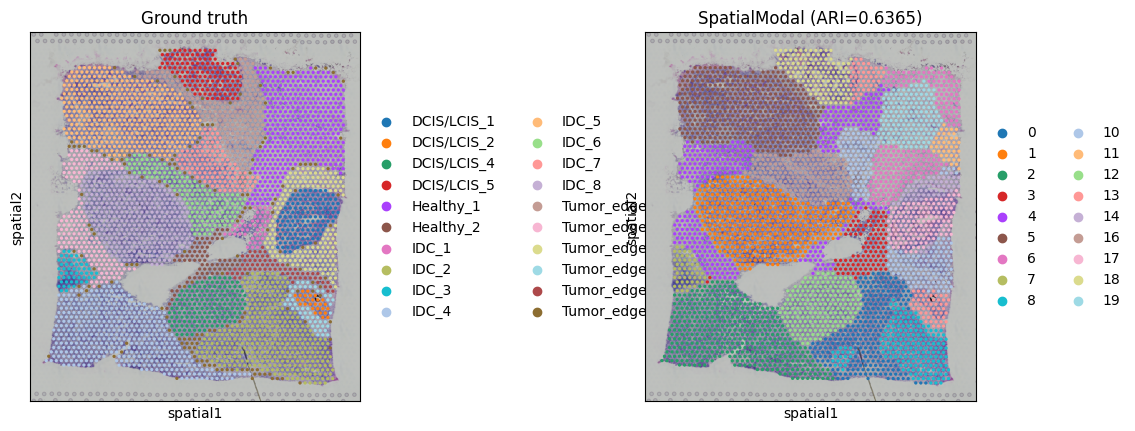

In [6]:
clustering(adata, n_clusters=20, radius=50, refinement=True)
adata.obs['domain_20'] = adata.obs['domain']
adata = sc.read_h5ad("/home/zhaodongmin/task_spa/result/BRCA_pic/h5ad/SpatialModal.h5ad")
ARI = metrics.adjusted_rand_score(adata.obs['ground_truth'], adata.obs['domain_20'])

sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain_20"],
              title=["Ground truth", "SpatialModal (ARI=%.4f)"%ARI],
              show=True)

#### **Pseudo-Spatiotemporal**

This section performs pseudotime inference by constructing a PAGA graph and calculating Diffusion Pseudotime (DPT) based on the learned multi-modal embeddings. We automatically identify a root cell using a distance-based approach and project the resulting pseudo-spatiotemporal map back onto the tissue coordinates to visualize the developmental gradients within the tumor microenvironment.

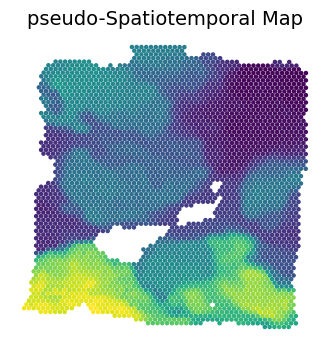

In [7]:
adata_psu = anndata.AnnData(adata.obsm['emb'])
sc.pp.neighbors(adata_psu, n_neighbors=20, use_rep='X')
sc.tl.umap(adata_psu)
sc.tl.leiden(adata_psu, resolution=1.0)
sc.tl.paga(adata_psu)
if adata_psu.shape[0] < 5000:
    sub_adata_x = adata_psu.X
else:
    indices = np.arange(adata_psu.shape[0])
    selected_ind = np.random.choice(indices, 5000, False)
    sub_adata_x = adata_psu.X[selected_ind, :]
sum_dists = distance_matrix(sub_adata_x, sub_adata_x).sum(axis=1)
adata_psu.uns['iroot'] = np.argmax(sum_dists)
sc.tl.diffmap(adata_psu)
sc.tl.dpt(adata_psu)
pSM_values = adata_psu.obs['dpt_pseudotime'].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x, y = adata.obsm["spatial"][:, 0], adata.obsm["spatial"][:, 1]
st = ax.scatter(x, y, s=20, c=pSM_values, marker=".")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

ax.invert_yaxis()
ax.set_title("pseudo-Spatiotemporal Map", fontsize=14)
plt.show()

#### **Spatial interaction**

Visualizing the spatial proximity and adjacency between identified domains ($n=20$) using Squidpy

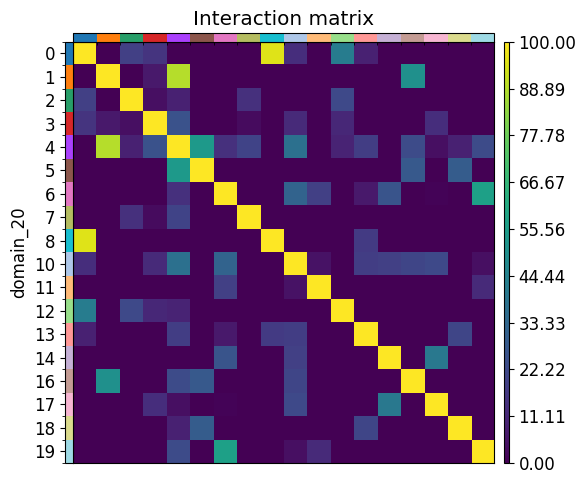

In [8]:
plt.rcParams['font.size'] = 12 

fig, ax = plt.subplots(figsize=(6, 5)) 

sq.gr.spatial_neighbors(adata)
sq.gr.interaction_matrix(adata, 'domain_20')

sq.pl.interaction_matrix(adata, 'domain_20', vmin=0, vmax=100, ax=ax, show=False)

plt.tight_layout() 
plt.show()

#### **Ripley's L Analysis**

Assessing the spatial distribution patterns of identified domains ($n=20$). The Ripley's L function quantifies whether specific domains exhibit significant spatial clustering, overdispersion, or random distribution across various distance scales.

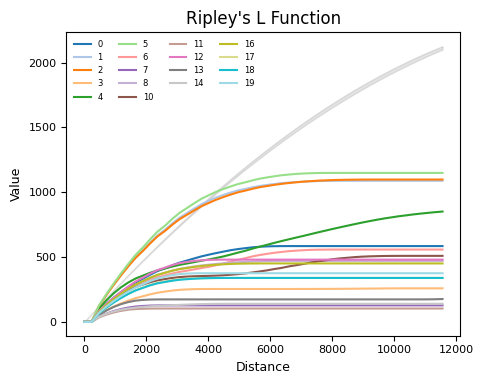

In [9]:
plt.rcParams["figure.figsize"] = (5, 4)

sq.gr.ripley(adata, 'domain_20', mode='L')


fig, ax = plt.subplots(figsize=(5, 4))


sq.pl.ripley(adata, 'domain_20', mode='L', ax=ax, palette='tab20')

ax.set_title("Ripley's L Function", fontsize=12) 
plt.legend(loc='upper left', ncol=4, fontsize=6, frameon=False) 

ax.set_xlabel("Distance", fontsize=9) 
ax.set_ylabel("Value", fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()